In [1]:
import sys
sys.path.append('../')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from fb_gp import saas_fbgp
import numpy as np
import time
import jax.numpy as jnp
from jax import random,vmap, grad
from jax.lax import while_loop
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from acquisition import EI, IPV, optim_scipy_bh
import scipy.optimize
from scipy.stats import qmc
from jaxns import NestedSampler
import corner
from nested_sampler import nested_sampling_jaxns, nested_sampling_Dy
from getdist import plots,MCSamples,loadMCSamples


matplotlib.rc('font', size=16,family='serif')
matplotlib.rc('legend', fontsize=16)

In [2]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 32
ndim = 4
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)

mean_r = 0.2
scale = 0.02


def f(X):
    r2 = (X[:,0]-0.5)**2 + (X[:,1]-0.4)**2
    r = np.sqrt(r2)
    return -0.5*((r-mean_r)/scale)**2

train_y = f(train_x).reshape(-1,1)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
# ax1.scatter(train_x[:,0],train_x[:,1])
# ax1.set_xlabel(r'$x_1$')
# ax1.set_ylabel(r'$x_2$')
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')

(32, 4) (32, 1)
Testing lightweight implementation


sample: 100%|██████████| 1024/1024 [00:03<00:00, 334.77it/s, 7 steps of size 7.33e-01. acc. prob=0.86]
INFO:[GP]: MCMC elapsed time: 4.93s



                              mean       std    median      5.0%     95.0%     n_eff     r_hat
_kernel_inv_length_sq[0]    108.19    122.55     59.29      3.96    299.96     46.24      0.98
_kernel_inv_length_sq[1]     98.09    109.07     55.05      3.68    217.33     47.27      0.97
_kernel_inv_length_sq[2]      0.14      0.16      0.09      0.01      0.41     20.16      1.05
_kernel_inv_length_sq[3]      0.05      0.10      0.01      0.00      0.14     25.71      0.99
        kernel_length[0]      0.43      0.04      0.42      0.38      0.48     52.59      0.97
        kernel_length[1]      0.45      0.05      0.45      0.37      0.51     31.97      1.00
        kernel_length[2]     13.17      5.86     13.01      4.01     19.57     19.54      1.03
        kernel_length[3]     57.98    105.41     33.79      5.15     87.00     32.26      1.01
            kernel_tausq      0.16      0.24      0.09      0.01      0.26     47.88      0.97
              kernel_var     10.08      3.96     

In [3]:
nsteps = 68 # 32
mc_points_size = 16
start = time.time()


ns_skip = 2
fit_skip = 1

for i in range(nsteps):
    if (i%ns_skip==0):
        samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
        print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
        size = len(samples)
        mc_points = samples[::int(size/mc_points_size),:]
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    x0 =  np.random.uniform(0,1,ndim)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=5,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)).reshape(-1,1)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    if (i%fit_skip==0):
        gp = saas_fbgp(train_x,train_y,noise=1e-6)
        gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    else:
        gp.quick_update(next_x,next_y)
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 5.01s
INFO:[NS]: jaxns did 38085 likelihood evaluations


LogZ info :logz_mean: = -0.8532, dlogz: = 0.3035, 


INFO:[AQ]: Acquisition optimization took 3.28 s


Next point at x = [0.37600561 0.27133618 0.52296079 0.89868317] with acquisition function value = 0.0011933245164487652


sample: 100%|██████████| 512/512 [00:16<00:00, 31.91it/s, 7 steps of size 5.91e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 16.87s


----------------------Step 1 complete----------------------



INFO:[AQ]: Acquisition optimization took 2.62 s


Next point at x = [0.59236724 0.40334954 0.51787543 0.43809075] with acquisition function value = 0.0009391253503020971


sample: 100%|██████████| 512/512 [00:12<00:00, 39.79it/s, 7 steps of size 6.05e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 13.40s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 3.26s
INFO:[NS]: jaxns did 43086 likelihood evaluations


LogZ info :logz_mean: = 3.7378, dlogz: = 0.3379, 


INFO:[AQ]: Acquisition optimization took 2.41 s


Next point at x = [0.39819224 0.64788962 0.21899447 0.02011918] with acquisition function value = 0.0002480463928373087


sample: 100%|██████████| 512/512 [00:02<00:00, 171.50it/s, 7 steps of size 4.77e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 3.57s


----------------------Step 3 complete----------------------



INFO:[AQ]: Acquisition optimization took 2.97 s


Next point at x = [0.40305144 0.64780919 0.11357566 0.03319558] with acquisition function value = 0.00017973319715290344


sample: 100%|██████████| 512/512 [00:03<00:00, 165.60it/s, 7 steps of size 6.40e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 3.53s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.63s
INFO:[NS]: jaxns did 39759 likelihood evaluations


LogZ info :logz_mean: = 11.4517, dlogz: = 0.3305, 


INFO:[AQ]: Acquisition optimization took 1.83 s


Next point at x = [0.53663839 0.23078456 0.01278252 0.14196316] with acquisition function value = 0.0005238933067951207


sample: 100%|██████████| 512/512 [00:03<00:00, 141.03it/s, 7 steps of size 4.51e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 4.07s


----------------------Step 5 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.59 s


Next point at x = [0.61721218 0.97066646 0.12628256 0.82694618] with acquisition function value = 0.0006689719979142911


sample: 100%|██████████| 512/512 [00:02<00:00, 198.57it/s, 7 steps of size 6.29e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 3.02s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.76s
INFO:[NS]: jaxns did 32246 likelihood evaluations


LogZ info :logz_mean: = -1.5571, dlogz: = 0.2697, 


INFO:[AQ]: Acquisition optimization took 1.76 s


Next point at x = [0.47748136 0.60689151 0.29592665 0.94198978] with acquisition function value = 0.0020033464718984956


sample: 100%|██████████| 512/512 [00:03<00:00, 162.00it/s, 7 steps of size 4.63e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 3.60s


----------------------Step 7 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.90 s


Next point at x = [0.31553635 0.49344233 0.04625222 0.89704588] with acquisition function value = 0.0008124730277996326


sample: 100%|██████████| 512/512 [00:05<00:00, 89.14it/s, 15 steps of size 3.81e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 6.25s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 3.81s
INFO:[NS]: jaxns did 42853 likelihood evaluations


LogZ info :logz_mean: = -1.2701, dlogz: = 0.2724, 


INFO:[AQ]: Acquisition optimization took 2.43 s


Next point at x = [0.71204116 0.3239207  0.2301272  0.1870393 ] with acquisition function value = 0.0006273014569009817


sample: 100%|██████████| 512/512 [00:03<00:00, 146.61it/s, 7 steps of size 4.53e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 4.04s


----------------------Step 9 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.63 s


Next point at x = [0.71947679 0.33562794 0.87638825 0.13688531] with acquisition function value = 0.00024937097605169656


sample: 100%|██████████| 512/512 [00:03<00:00, 146.11it/s, 15 steps of size 3.26e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 4.00s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 2.37s
INFO:[NS]: jaxns did 36203 likelihood evaluations


LogZ info :logz_mean: = -2.3890, dlogz: = 0.2632, 


INFO:[AQ]: Acquisition optimization took 2.33 s


Next point at x = [0.28161931 0.32992246 0.09684081 0.80095625] with acquisition function value = 0.0002187816010253323


sample: 100%|██████████| 512/512 [00:03<00:00, 141.79it/s, 7 steps of size 3.22e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 4.10s


----------------------Step 11 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.57 s


Next point at x = [0.         0.85326179 0.1061527  0.5376541 ] with acquisition function value = 0.0004176096353042495


sample: 100%|██████████| 512/512 [00:03<00:00, 144.20it/s, 7 steps of size 4.45e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 4.08s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 2.90s
INFO:[NS]: jaxns did 35744 likelihood evaluations


LogZ info :logz_mean: = -2.7161, dlogz: = 0.2699, 


INFO:[AQ]: Acquisition optimization took 1.81 s


Next point at x = [0.38773455 0.23863143 0.         0.65105914] with acquisition function value = 0.000407819401197251


sample: 100%|██████████| 512/512 [00:03<00:00, 159.12it/s, 15 steps of size 3.32e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 3.69s


----------------------Step 13 complete----------------------



INFO:[AQ]: Acquisition optimization took 2.04 s


Next point at x = [0.35876595 0.29281447 0.35586633 0.89873613] with acquisition function value = 0.00022468607410690462


sample: 100%|██████████| 512/512 [00:03<00:00, 139.19it/s, 7 steps of size 2.92e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 4.16s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.35s
INFO:[NS]: jaxns did 32256 likelihood evaluations


LogZ info :logz_mean: = -2.1780, dlogz: = 0.2696, 


INFO:[AQ]: Acquisition optimization took 2.11 s


Next point at x = [0.5138649  0.1962838  0.92898281 0.09841762] with acquisition function value = 0.00026635769286549073


sample: 100%|██████████| 512/512 [00:03<00:00, 135.69it/s, 15 steps of size 3.22e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 4.29s


----------------------Step 15 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.63 s


Next point at x = [0.49865175 0.18729915 0.8552181  0.01548908] with acquisition function value = 0.00010899785668522883


sample: 100%|██████████| 512/512 [00:04<00:00, 124.16it/s, 7 steps of size 4.45e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 4.65s


----------------------Step 16 complete----------------------



INFO:[NS]: Nested Sampling took 3.36s
INFO:[NS]: jaxns did 33931 likelihood evaluations


LogZ info :logz_mean: = -2.6459, dlogz: = 0.2566, 


INFO:[AQ]: Acquisition optimization took 1.23 s


Next point at x = [0.37057497 0.26113679 0.31742565 0.46881733] with acquisition function value = 7.102476127367197e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 145.73it/s, 15 steps of size 4.52e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 4.00s


----------------------Step 17 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.64 s


Next point at x = [0.57434681 0.08506984 0.05850849 0.        ] with acquisition function value = 4.502037221192166e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 163.40it/s, 7 steps of size 5.79e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.65s


----------------------Step 18 complete----------------------



INFO:[NS]: Nested Sampling took 2.42s
INFO:[NS]: jaxns did 33194 likelihood evaluations


LogZ info :logz_mean: = -2.6184, dlogz: = 0.2515, 


INFO:[AQ]: Acquisition optimization took 0.71 s


Next point at x = [0.41849091 0.70051802 0.38792846 0.53932759] with acquisition function value = 7.17759634016081e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 96.74it/s, 15 steps of size 2.98e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 5.80s


----------------------Step 19 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.03 s


Next point at x = [0.5515274  0.6089801  0.21146655 0.7571008 ] with acquisition function value = 3.9314555766259765e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 113.72it/s, 15 steps of size 3.08e-01. acc. prob=0.95]
INFO:[GP]: MCMC elapsed time: 5.04s


----------------------Step 20 complete----------------------



INFO:[NS]: Nested Sampling took 2.87s
INFO:[NS]: jaxns did 29876 likelihood evaluations


LogZ info :logz_mean: = -2.9788, dlogz: = 0.2478, 


INFO:[AQ]: Acquisition optimization took 0.75 s


Next point at x = [0.4152986  0.66433086 0.1794291  0.        ] with acquisition function value = 4.820944065197716e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 115.04it/s, 15 steps of size 2.99e-01. acc. prob=0.96]
INFO:[GP]: MCMC elapsed time: 4.95s


----------------------Step 21 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.61 s


Next point at x = [0.47369832 0.57956519 0.         0.47716518] with acquisition function value = 4.0239973311497444e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 121.64it/s, 15 steps of size 3.53e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 4.69s


----------------------Step 22 complete----------------------



INFO:[NS]: Nested Sampling took 2.74s
INFO:[NS]: jaxns did 31429 likelihood evaluations


LogZ info :logz_mean: = -3.0900, dlogz: = 0.2545, 


INFO:[AQ]: Acquisition optimization took 0.73 s


Next point at x = [0.15686096 0.14642169 0.         0.84811574] with acquisition function value = 0.00010887014942380585


sample: 100%|██████████| 512/512 [00:04<00:00, 111.98it/s, 7 steps of size 3.82e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 5.13s


----------------------Step 23 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.73 s


Next point at x = [0.59629405 0.60063089 0.99574264 0.40030522] with acquisition function value = 3.714849753962048e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 96.63it/s, 15 steps of size 4.31e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 5.90s


----------------------Step 24 complete----------------------



INFO:[NS]: Nested Sampling took 2.95s
INFO:[NS]: jaxns did 28908 likelihood evaluations


LogZ info :logz_mean: = -2.9698, dlogz: = 0.2433, 


INFO:[AQ]: Acquisition optimization took 0.49 s


Next point at x = [1.         0.85932969 0.81585279 0.66616427] with acquisition function value = 4.824782130138927e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 111.19it/s, 15 steps of size 3.78e-01. acc. prob=0.80]
INFO:[GP]: MCMC elapsed time: 5.14s


----------------------Step 25 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.60 s


Next point at x = [0.70683357 0.78277538 0.12622222 0.06611595] with acquisition function value = 3.8677010895535324e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 135.52it/s, 7 steps of size 4.85e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 4.33s


----------------------Step 26 complete----------------------



INFO:[NS]: Nested Sampling took 2.50s
INFO:[NS]: jaxns did 28210 likelihood evaluations


LogZ info :logz_mean: = -2.9962, dlogz: = 0.2480, 


INFO:[AQ]: Acquisition optimization took 0.69 s


Next point at x = [0.60441853 0.25691884 0.74155049 0.00615605] with acquisition function value = 1.9369155936112964e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 116.92it/s, 15 steps of size 4.88e-01. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 4.95s


----------------------Step 27 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.55 s


Next point at x = [0.82334271 0.36228338 0.84034258 0.77676889] with acquisition function value = 2.133067699590721e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 89.74it/s, 7 steps of size 4.73e-01. acc. prob=0.89]  
INFO:[GP]: MCMC elapsed time: 6.29s


----------------------Step 28 complete----------------------



INFO:[NS]: Nested Sampling took 2.36s
INFO:[NS]: jaxns did 36344 likelihood evaluations


LogZ info :logz_mean: = -2.5682, dlogz: = 0.2468, 


INFO:[AQ]: Acquisition optimization took 1.34 s


Next point at x = [0.2899659  0.41295863 0.56483786 0.45544854] with acquisition function value = 2.8051993188122314e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 106.45it/s, 7 steps of size 5.69e-01. acc. prob=0.83] 
INFO:[GP]: MCMC elapsed time: 5.40s


----------------------Step 29 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.56 s


Next point at x = [0.34294392 0.55218235 0.77457319 0.96973215] with acquisition function value = 1.543278156678103e-05


sample: 100%|██████████| 512/512 [00:04<00:00, 110.70it/s, 15 steps of size 3.81e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 5.18s


----------------------Step 30 complete----------------------



INFO:[NS]: Nested Sampling took 2.48s
INFO:[NS]: jaxns did 30285 likelihood evaluations


LogZ info :logz_mean: = -2.7283, dlogz: = 0.2443, 


INFO:[AQ]: Acquisition optimization took 0.52 s


Next point at x = [0.65560341 0.7530462  0.55299698 0.72715041] with acquisition function value = 2.6005926074474002e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 89.00it/s, 15 steps of size 3.04e-01. acc. prob=0.96] 
INFO:[GP]: MCMC elapsed time: 6.36s


----------------------Step 31 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.20 s


Next point at x = [0.4617384  0.44987473 0.13693921 0.73732496] with acquisition function value = 1.8755644833115363e-05


sample: 100%|██████████| 512/512 [00:06<00:00, 78.20it/s, 11 steps of size 2.99e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 7.69s


----------------------Step 32 complete----------------------



INFO:[NS]: Nested Sampling took 2.64s
INFO:[NS]: jaxns did 38621 likelihood evaluations


LogZ info :logz_mean: = -1.6624, dlogz: = 0.2572, 


INFO:[AQ]: Acquisition optimization took 10.20 s


Next point at x = [0.6856456  0.47801859 0.39036441 0.11753516] with acquisition function value = 7.245331173277511e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 70.07it/s, 15 steps of size 2.68e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 8.16s


----------------------Step 33 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.51 s


Next point at x = [0.683478   0.41240882 0.27232381 0.73847278] with acquisition function value = 2.7318030984384897e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 93.79it/s, 7 steps of size 6.06e-01. acc. prob=0.88]  
INFO:[GP]: MCMC elapsed time: 6.28s


----------------------Step 34 complete----------------------



INFO:[NS]: Nested Sampling took 2.70s
INFO:[NS]: jaxns did 34460 likelihood evaluations


LogZ info :logz_mean: = -2.1835, dlogz: = 0.2496, 


INFO:[AQ]: Acquisition optimization took 1.66 s


Next point at x = [0.23431756 0.12821892 0.53146563 0.4194404 ] with acquisition function value = 4.35278008107335e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 95.05it/s, 7 steps of size 5.52e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 6.19s


----------------------Step 35 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.09 s


Next point at x = [0.67476656 0.6874234  0.28235482 0.78227418] with acquisition function value = 3.750492568556363e-05


sample: 100%|██████████| 512/512 [00:06<00:00, 78.54it/s, 7 steps of size 5.85e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 7.27s


----------------------Step 36 complete----------------------



INFO:[NS]: Nested Sampling took 2.56s
INFO:[NS]: jaxns did 34090 likelihood evaluations


LogZ info :logz_mean: = -2.1110, dlogz: = 0.2506, 


INFO:[AQ]: Acquisition optimization took 1.39 s


Next point at x = [0.2329978  0.75464761 0.68145932 0.15238304] with acquisition function value = 3.4664141576636054e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 92.06it/s, 7 steps of size 5.98e-01. acc. prob=0.87]  
INFO:[GP]: MCMC elapsed time: 6.38s


----------------------Step 37 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.60 s


Next point at x = [0.34939404 0.62667039 0.40895664 0.98236496] with acquisition function value = 4.914543777368753e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 96.53it/s, 7 steps of size 5.15e-01. acc. prob=0.93]  
INFO:[GP]: MCMC elapsed time: 6.95s


----------------------Step 38 complete----------------------



INFO:[NS]: Nested Sampling took 2.53s
INFO:[NS]: jaxns did 32547 likelihood evaluations


LogZ info :logz_mean: = -2.4101, dlogz: = 0.2482, 


INFO:[AQ]: Acquisition optimization took 2.15 s


Next point at x = [0.66371361 0.53635912 0.10109678 0.71002863] with acquisition function value = 2.5535175886814802e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 85.47it/s, 7 steps of size 5.33e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 6.74s


----------------------Step 39 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.04 s


Next point at x = [0.45820735 0.82550116 0.95441285 0.22648413] with acquisition function value = 2.916873353123444e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 95.86it/s, 3 steps of size 7.94e-01. acc. prob=0.84]  
INFO:[GP]: MCMC elapsed time: 6.15s


----------------------Step 40 complete----------------------



INFO:[NS]: Nested Sampling took 2.56s
INFO:[NS]: jaxns did 31336 likelihood evaluations


LogZ info :logz_mean: = -2.3843, dlogz: = 0.2461, 


INFO:[AQ]: Acquisition optimization took 2.96 s


Next point at x = [0.30900738 0.29017076 0.6977052  0.2591617 ] with acquisition function value = 1.9566150292870538e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 96.24it/s, 7 steps of size 6.52e-01. acc. prob=0.90]  
INFO:[GP]: MCMC elapsed time: 6.19s


----------------------Step 41 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.16 s


Next point at x = [0.89375255 0.60945555 0.         0.29821683] with acquisition function value = 2.203250331733308e-05


sample: 100%|██████████| 512/512 [00:06<00:00, 74.70it/s, 7 steps of size 5.25e-01. acc. prob=0.93]  
INFO:[GP]: MCMC elapsed time: 7.67s


----------------------Step 42 complete----------------------



INFO:[NS]: Nested Sampling took 2.60s
INFO:[NS]: jaxns did 32272 likelihood evaluations


LogZ info :logz_mean: = -2.3779, dlogz: = 0.2430, 


INFO:[AQ]: Acquisition optimization took 2.09 s


Next point at x = [0.64317229 0.23473989 0.75874519 0.36348174] with acquisition function value = 1.4278826890790595e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 88.94it/s, 7 steps of size 5.69e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 6.62s


----------------------Step 43 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.00 s


Next point at x = [0.58087452 0.60627471 0.87186756 0.19752512] with acquisition function value = 1.5096324723427e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 88.44it/s, 7 steps of size 6.25e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 6.53s


----------------------Step 44 complete----------------------



INFO:[NS]: Nested Sampling took 2.59s
INFO:[NS]: jaxns did 31531 likelihood evaluations


LogZ info :logz_mean: = -2.4743, dlogz: = 0.2451, 


INFO:[AQ]: Acquisition optimization took 1.44 s


Next point at x = [0.72800603 0.43664987 0.62612144 0.46918819] with acquisition function value = 1.594852029642834e-05


sample: 100%|██████████| 512/512 [00:09<00:00, 54.75it/s, 7 steps of size 6.56e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 10.29s


----------------------Step 45 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.25 s


Next point at x = [0.0200763  0.15780308 0.59849899 0.51531209] with acquisition function value = 1.770151709024493e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 65.30it/s, 7 steps of size 6.80e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 8.91s


----------------------Step 46 complete----------------------



INFO:[NS]: Nested Sampling took 2.70s
INFO:[NS]: jaxns did 32050 likelihood evaluations


LogZ info :logz_mean: = -2.5335, dlogz: = 0.2474, 


INFO:[AQ]: Acquisition optimization took 1.21 s


Next point at x = [0.18001115 0.16642138 0.         0.93334537] with acquisition function value = 2.438720762558931e-05


sample: 100%|██████████| 512/512 [00:08<00:00, 57.75it/s, 7 steps of size 4.81e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 9.74s


----------------------Step 47 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.21 s


Next point at x = [0.42814761 0.53602874 0.09432076 0.7804985 ] with acquisition function value = 2.9210295504565262e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 68.22it/s, 7 steps of size 6.71e-01. acc. prob=0.86]  
INFO:[GP]: MCMC elapsed time: 8.40s


----------------------Step 48 complete----------------------



INFO:[NS]: Nested Sampling took 2.59s
INFO:[NS]: jaxns did 32589 likelihood evaluations


LogZ info :logz_mean: = -2.4494, dlogz: = 0.2455, 


INFO:[AQ]: Acquisition optimization took 1.16 s


Next point at x = [0.21542092 0.2913794  0.26962378 0.00203496] with acquisition function value = 1.8492564739616343e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 69.37it/s, 7 steps of size 5.86e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 8.14s


----------------------Step 49 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.21 s


Next point at x = [0.         0.30133463 0.30399417 0.60921041] with acquisition function value = 2.0983896150093828e-05


sample: 100%|██████████| 512/512 [00:08<00:00, 57.96it/s, 3 steps of size 5.99e-01. acc. prob=0.87] 
INFO:[GP]: MCMC elapsed time: 9.69s


----------------------Step 50 complete----------------------



INFO:[NS]: Nested Sampling took 2.73s
INFO:[NS]: jaxns did 32192 likelihood evaluations


LogZ info :logz_mean: = -2.4094, dlogz: = 0.2456, 


INFO:[AQ]: Acquisition optimization took 1.31 s


Next point at x = [0.40632564 0.10859541 0.57417126 0.89722922] with acquisition function value = 1.9039645480279678e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 70.78it/s, 7 steps of size 4.69e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 8.14s


----------------------Step 51 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.17 s


Next point at x = [0.32944844 0.50619818 0.25963078 0.79920023] with acquisition function value = 1.5169076203228396e-05


sample: 100%|██████████| 512/512 [00:06<00:00, 78.88it/s, 7 steps of size 6.32e-01. acc. prob=0.90]  
INFO:[GP]: MCMC elapsed time: 7.30s


----------------------Step 52 complete----------------------



INFO:[NS]: Nested Sampling took 2.58s
INFO:[NS]: jaxns did 32258 likelihood evaluations


LogZ info :logz_mean: = -2.2848, dlogz: = 0.2411, 


INFO:[AQ]: Acquisition optimization took 1.20 s


Next point at x = [0.86050248 0.40202551 0.46947694 0.64354677] with acquisition function value = 2.4447376780881158e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 67.69it/s, 7 steps of size 5.26e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 8.41s


----------------------Step 53 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.28 s


Next point at x = [0.49439713 0.52843278 0.33926319 0.5860883 ] with acquisition function value = 2.3652179006275822e-05


sample: 100%|██████████| 512/512 [00:09<00:00, 55.52it/s, 7 steps of size 7.33e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 10.11s


----------------------Step 54 complete----------------------



INFO:[NS]: Nested Sampling took 3.32s
INFO:[NS]: jaxns did 28328 likelihood evaluations


LogZ info :logz_mean: = -2.2037, dlogz: = 0.2432, 


INFO:[AQ]: Acquisition optimization took 1.20 s


Next point at x = [0.26293836 0.77378668 0.87178331 0.07922723] with acquisition function value = 3.2307372630833824e-05


sample: 100%|██████████| 512/512 [00:08<00:00, 59.76it/s, 7 steps of size 6.03e-01. acc. prob=0.91]  
INFO:[GP]: MCMC elapsed time: 9.56s


----------------------Step 55 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.78 s


Next point at x = [0.34087367 0.53505467 0.03709066 0.29241793] with acquisition function value = 3.100255714201614e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 64.48it/s, 7 steps of size 5.86e-01. acc. prob=0.91]  
INFO:[GP]: MCMC elapsed time: 8.77s


----------------------Step 56 complete----------------------



INFO:[NS]: Nested Sampling took 2.70s
INFO:[NS]: jaxns did 27258 likelihood evaluations


LogZ info :logz_mean: = -2.3620, dlogz: = 0.2450, 


INFO:[AQ]: Acquisition optimization took 1.21 s


Next point at x = [0.13090408 0.18519688 0.89961301 0.77546705] with acquisition function value = 3.773660859043154e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 66.47it/s, 7 steps of size 5.90e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 8.55s


----------------------Step 57 complete----------------------



INFO:[AQ]: Acquisition optimization took 2.57 s


Next point at x = [0.66008739 0.62085036 0.99988273 0.8090926 ] with acquisition function value = 3.7540200197251974e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 72.61it/s, 7 steps of size 7.86e-01. acc. prob=0.87]  
INFO:[GP]: MCMC elapsed time: 7.98s


----------------------Step 58 complete----------------------



INFO:[NS]: Nested Sampling took 2.80s
INFO:[NS]: jaxns did 30771 likelihood evaluations


LogZ info :logz_mean: = -2.1981, dlogz: = 0.2417, 


INFO:[AQ]: Acquisition optimization took 1.30 s


Next point at x = [0.45419862 0.96018509 0.         0.07109871] with acquisition function value = 3.341404316406244e-05


sample: 100%|██████████| 512/512 [00:08<00:00, 57.33it/s, 7 steps of size 6.60e-01. acc. prob=0.89]  
INFO:[GP]: MCMC elapsed time: 9.91s


----------------------Step 59 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.36 s


Next point at x = [0.5150032  0.69849997 0.10575138 0.61107848] with acquisition function value = 3.4092267996454345e-05


sample: 100%|██████████| 512/512 [00:08<00:00, 58.26it/s, 7 steps of size 7.30e-01. acc. prob=0.87] 
INFO:[GP]: MCMC elapsed time: 9.70s


----------------------Step 60 complete----------------------



INFO:[NS]: Nested Sampling took 2.69s
INFO:[NS]: jaxns did 27698 likelihood evaluations


LogZ info :logz_mean: = -2.2204, dlogz: = 0.2415, 


INFO:[AQ]: Acquisition optimization took 1.20 s


Next point at x = [0.17291543 0.55498275 0.70190733 0.57451184] with acquisition function value = 2.936034255102398e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 66.61it/s, 7 steps of size 5.97e-01. acc. prob=0.90]  
INFO:[GP]: MCMC elapsed time: 8.55s


----------------------Step 61 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.41 s


Next point at x = [0.38209654 0.14689044 0.09135717 0.36715275] with acquisition function value = 2.5725366857968363e-05


sample: 100%|██████████| 512/512 [00:08<00:00, 62.88it/s, 7 steps of size 6.04e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 8.95s


----------------------Step 62 complete----------------------



INFO:[NS]: Nested Sampling took 2.65s
INFO:[NS]: jaxns did 26908 likelihood evaluations


LogZ info :logz_mean: = -2.2901, dlogz: = 0.2414, 


INFO:[AQ]: Acquisition optimization took 2.48 s


Next point at x = [0.59363451 0.20834793 0.10274972 0.66741892] with acquisition function value = 1.480433011304301e-05


sample: 100%|██████████| 512/512 [00:08<00:00, 62.69it/s, 7 steps of size 5.99e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 9.10s


----------------------Step 63 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.34 s


Next point at x = [0.4377034  0.68899782 0.16268602 0.65501384] with acquisition function value = 1.6045400524798345e-05


sample: 100%|██████████| 512/512 [00:06<00:00, 81.85it/s, 7 steps of size 6.66e-01. acc. prob=0.89]  
INFO:[GP]: MCMC elapsed time: 7.09s


----------------------Step 64 complete----------------------



INFO:[NS]: Nested Sampling took 2.71s
INFO:[NS]: jaxns did 29288 likelihood evaluations


LogZ info :logz_mean: = -2.3763, dlogz: = 0.2360, 


INFO:[AQ]: Acquisition optimization took 1.38 s


Next point at x = [1.         0.91555329 0.19330295 0.30329994] with acquisition function value = 1.7548437303405336e-05


sample: 100%|██████████| 512/512 [00:09<00:00, 53.75it/s, 7 steps of size 6.42e-01. acc. prob=0.91]  
INFO:[GP]: MCMC elapsed time: 10.38s


----------------------Step 65 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.32 s


Next point at x = [0.66562378 0.8912017  0.07211323 0.50991223] with acquisition function value = 1.3727284341587438e-05


sample: 100%|██████████| 512/512 [00:12<00:00, 41.63it/s, 7 steps of size 7.24e-01. acc. prob=0.88] 
INFO:[GP]: MCMC elapsed time: 13.20s


----------------------Step 66 complete----------------------



INFO:[NS]: Nested Sampling took 2.66s
INFO:[NS]: jaxns did 27718 likelihood evaluations


LogZ info :logz_mean: = -2.3627, dlogz: = 0.2369, 


INFO:[AQ]: Acquisition optimization took 1.21 s


Next point at x = [0.28946417 0.55659227 1.         0.52781189] with acquisition function value = 2.0131171335865256e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 71.79it/s, 7 steps of size 7.35e-01. acc. prob=0.87] 
INFO:[GP]: MCMC elapsed time: 8.07s


----------------------Step 67 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.83 s


Next point at x = [0.70199401 0.71218654 0.67886928 0.037595  ] with acquisition function value = 2.704047239424686e-05


sample: 100%|██████████| 512/512 [00:10<00:00, 47.60it/s, 7 steps of size 6.19e-01. acc. prob=0.91]  
INFO:[GP]: MCMC elapsed time: 11.71s


----------------------Step 68 complete----------------------

BO took 696.89 s 


In [4]:
print(gp.train_x.shape,gp.train_y.shape)

(100, 4) (100, 1)


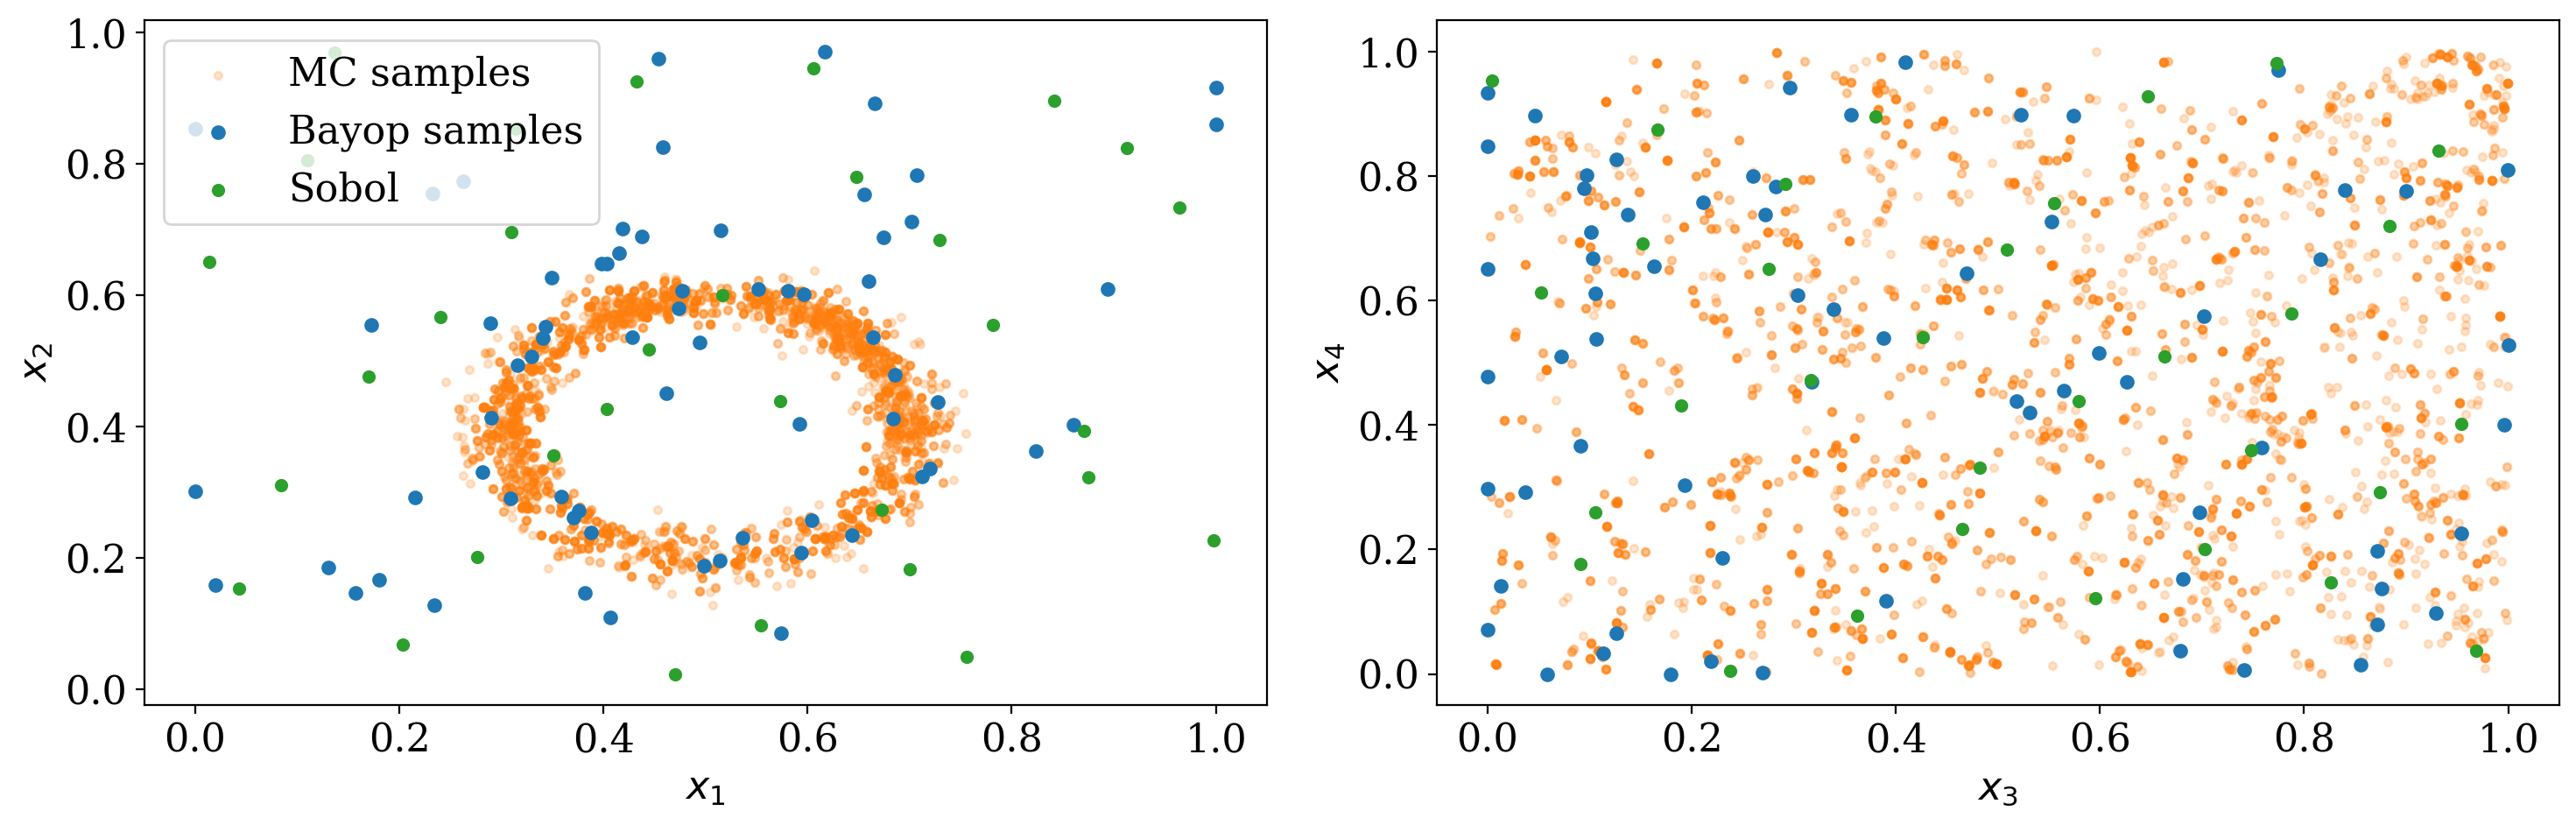

In [5]:
fig,ax = plt.subplots(1,int(ndim/2),figsize=(15,5))
for i,x in enumerate(ax):
    x.scatter(samples[:,2*i],samples[:,2*i+1],s=10,label='MC samples',color='C1',alpha=0.2)
    x.scatter(train_x[ninit:,2*i],train_x[ninit:,2*i+1],s=25,label='Bayop samples',color='C0')
    x.scatter(train_x[:ninit,2*i],train_x[:ninit,2*i+1],s=20,label='Sobol',color='C2')
    x.set_ylabel(r'$x_{{%i}}$'%(2*i+2))
    x.set_xlabel(r'$x_{{{}}}$'.format(2*i+1))
    # x.axvline(f_mean[2*i],ls='-.',color='k')
    # x.axhline(f_mean[2*i + 1],ls='-.',color='k')
ax[0].legend()
fig.tight_layout()

In [6]:
print(gp.get_median_lengthscales())

[1.75865858e-01 1.52326611e-01 1.85456895e+01 1.99603901e+02]


In [7]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 11.81s
INFO:[NS]: jaxns did 410068 likelihood evaluations


LogZ logz_mean: -2.5152, dlogz: 0.1375, 


Removed no burn in
Removed no burn in


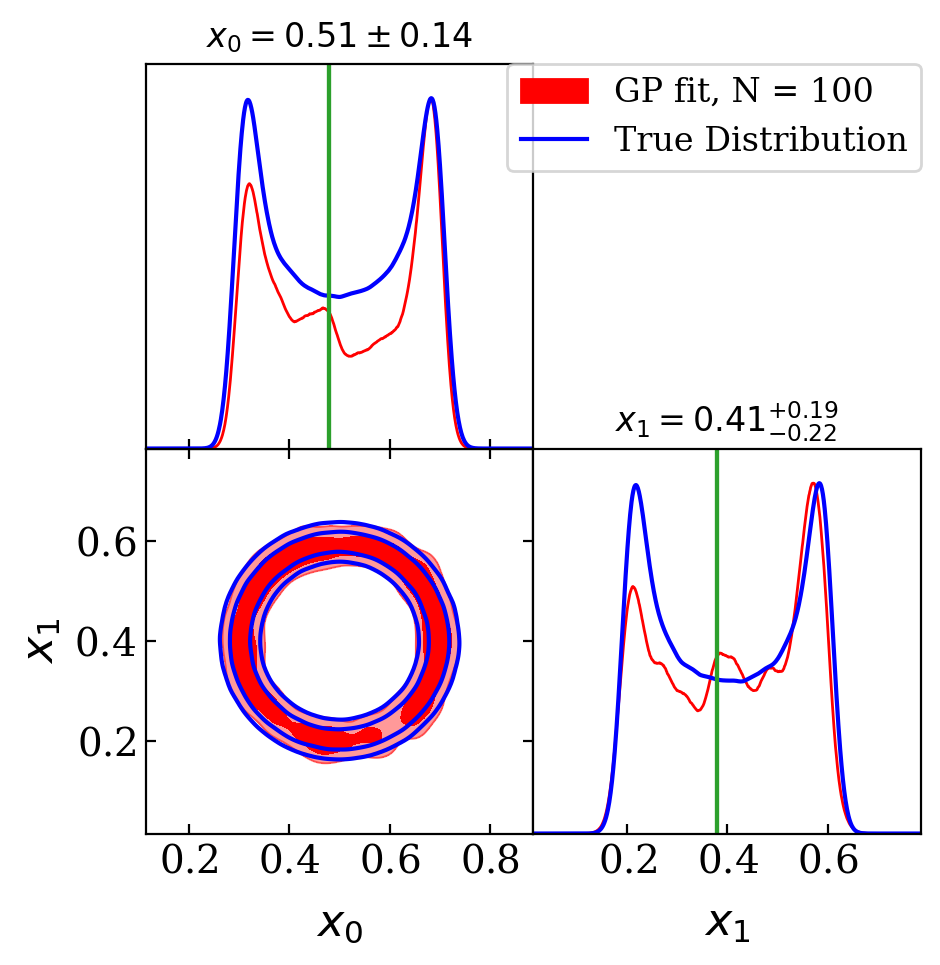

In [13]:
size = int(5e5)
rs = np.random.normal(loc=mean_r,scale=scale,size=size)
thetas = 2*np.pi*np.random.rand(size)
xs = abs(rs)*np.cos(thetas)+0.5
ys = abs(rs)*np.sin(thetas)+0.4
xys = np.array([xs,ys]).T

labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=xys,names=names[:2], labels = labels[:2],ranges=ranges[:2]) # a comparison run
gp_samples = MCSamples(samples=samples[::2],names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names[:2],filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]}','True Distribution'],
                                contour_lws=[1,1.5],title_limit=1,)
                                # markers = dict(zip(names[:2],[0.])),
                                # marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'}) # type: ignore

locs = np.array([0.5,0.4])
for i in range(2):
    ax = g.subplots[i,i]
    ax.axvline(locs[i]-scale, color='C2', ls='-')
    ax.axvline(locs[i]-scale, color='C2', ls='-')




In [ ]:
np.random.seed(10004118) # fixed for reproducibility
# train_x = np.random.uniform(0,1,(12,2))
ninit = 32
ndim = 2
train_x = qmc.Sobol(ndim, scramble=True).random(ninit)

mean_r = 0.2
scale = 0.02


def f(X):
    r2 = (X[:,0]-0.5)**2 + (X[:,1]-0.4)**2
    r = np.sqrt(r2)
    return -0.5*((r-mean_r)/scale)**2

train_y = f(train_x).reshape(-1,1)
print(train_x.shape,train_y.shape)

train_yvar = 1e-6*jnp.ones_like(train_y)

print("Testing lightweight implementation")

gp = saas_fbgp(train_x,train_y,noise=1e-6)
seed = 0
rng_key, _ = random.split(random.PRNGKey(seed), 2)
gp.fit(rng_key,warmup_steps=512,num_samples=512,thinning=16,verbose=True)

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
# ax1.scatter(train_x[:,0],train_x[:,1])
# ax1.set_xlabel(r'$x_1$')
# ax1.set_ylabel(r'$x_2$')
# ax2.scatter(train_x[:,2],train_x[:,3])
# ax2.set_xlabel(r'$x_3$')
# ax2.set_ylabel(r'$x_4$')

(32, 2) (32, 1)
Testing lightweight implementation


warmup:  28%|██▊       | 289/1024 [00:01<00:01, 414.68it/s, 3 steps of size 4.35e-01. acc. prob=0.78] 

In [ ]:
nsteps = 68 # 32
mc_points_size = 16
start = time.time()


ns_skip = 1
fit_skip = 1

for i in range(nsteps):
    if (i%ns_skip==0):
        samples, logz_dict = samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.1)
        print(f"LogZ info :"+"".join(f"{key}: = {value:.4f}, " for key, value in logz_dict.items()))
        size = len(samples)
        mc_points = samples[::int(size/mc_points_size),:]
    acq_func = IPV(gp,mc_points)
    grad_fn = grad(acq_func)
    x0 =  np.random.uniform(0,1,ndim)
    results = optim_scipy_bh(acq_func,x0=x0,stepsize=1/4,
                                      niter=10,minimizer_kwargs={'jac': grad_fn, 'bounds': ndim*[(0,1)] })
    print(f"Next point at x = {results.x} with acquisition function value = {results.fun}")
    next_x = jnp.atleast_2d(results.x)
    next_y = f((next_x)).reshape(-1,1)
    train_x = jnp.concatenate([train_x,next_x])
    train_y = jnp.concatenate([train_y,next_y])
    seed = i
    rng_key, _ = random.split(random.PRNGKey(seed), 2)
    if (i%fit_skip==0):
        gp = saas_fbgp(train_x,train_y,noise=1e-6)
        gp.fit(rng_key,warmup_steps=256,num_samples=256,thinning=16,verbose=False) # change rng key?
    else:
        gp.quick_update(next_x,next_y)
    print(f"----------------------Step {i+1} complete----------------------\n")


print(f"BO took {time.time() - start:.2f} s ")

INFO:[NS]: Nested Sampling took 3.62s
INFO:[NS]: jaxns did 10767 likelihood evaluations


LogZ info :logz_mean: = -3.2864, dlogz: = 0.3152, 


INFO:[AQ]: Acquisition optimization took 0.83 s


Next point at x = [0.86089403 0.3198643 ] with acquisition function value = 2.6516913315003353e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 296.66it/s, 7 steps of size 7.40e-01. acc. prob=0.88]
INFO:[GP]: MCMC elapsed time: 2.29s


----------------------Step 1 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.56 s


Next point at x = [0.94577606 0.09206991] with acquisition function value = 2.3906968705720427e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 216.41it/s, 7 steps of size 6.29e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 2.82s


----------------------Step 2 complete----------------------



INFO:[NS]: Nested Sampling took 1.87s
INFO:[NS]: jaxns did 10962 likelihood evaluations


LogZ info :logz_mean: = -3.7043, dlogz: = 0.3239, 


INFO:[AQ]: Acquisition optimization took 0.88 s


Next point at x = [0.29233901 0.38102813] with acquisition function value = 1.4657645444057094e-05


sample: 100%|██████████| 512/512 [00:01<00:00, 261.01it/s, 7 steps of size 5.38e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 2.38s


----------------------Step 3 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.50 s


Next point at x = [0.90140365 0.4291591 ] with acquisition function value = 5.127301372794338e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 248.39it/s, 3 steps of size 6.59e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 2.49s


----------------------Step 4 complete----------------------



INFO:[NS]: Nested Sampling took 2.41s
INFO:[NS]: jaxns did 12422 likelihood evaluations


LogZ info :logz_mean: = -3.6252, dlogz: = 0.3160, 


INFO:[AQ]: Acquisition optimization took 1.11 s


Next point at x = [0.65496068 0.56198198] with acquisition function value = 2.45639662314074e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 174.11it/s, 3 steps of size 6.51e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 3.38s


----------------------Step 5 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.77 s


Next point at x = [0.22941583 0.2920756 ] with acquisition function value = 1.2931018459082233e-05


sample: 100%|██████████| 512/512 [00:05<00:00, 98.24it/s, 3 steps of size 6.93e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 5.64s


----------------------Step 6 complete----------------------



INFO:[NS]: Nested Sampling took 2.42s
INFO:[NS]: jaxns did 10379 likelihood evaluations


LogZ info :logz_mean: = -3.8662, dlogz: = 0.3082, 


INFO:[AQ]: Acquisition optimization took 0.65 s


Next point at x = [0.47640586 0.55374371] with acquisition function value = 5.351978242229202e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 182.48it/s, 7 steps of size 6.86e-01. acc. prob=0.89]
INFO:[GP]: MCMC elapsed time: 3.30s


----------------------Step 7 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.72 s


Next point at x = [0.5635771  0.67592558] with acquisition function value = 1.5634379303281973e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 231.98it/s, 7 steps of size 7.73e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 2.66s


----------------------Step 8 complete----------------------



INFO:[NS]: Nested Sampling took 1.89s
INFO:[NS]: jaxns did 10749 likelihood evaluations


LogZ info :logz_mean: = -3.5639, dlogz: = 0.3080, 


INFO:[AQ]: Acquisition optimization took 1.43 s


Next point at x = [0.66093127 0.26243514] with acquisition function value = 8.909038551474166e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 230.30it/s, 7 steps of size 7.34e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 2.72s


----------------------Step 9 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.55 s


Next point at x = [0.44808235 0.57573135] with acquisition function value = 6.163594217321183e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 183.54it/s, 7 steps of size 5.25e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.25s


----------------------Step 10 complete----------------------



INFO:[NS]: Nested Sampling took 1.93s
INFO:[NS]: jaxns did 10973 likelihood evaluations


LogZ info :logz_mean: = -3.1647, dlogz: = 0.2996, 


INFO:[AQ]: Acquisition optimization took 0.87 s


Next point at x = [0.95526247 0.33738699] with acquisition function value = 3.2174627428835714e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 133.70it/s, 7 steps of size 6.89e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 4.32s


----------------------Step 11 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.59 s


Next point at x = [0.61701578 0.79134358] with acquisition function value = 3.267346913412954e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 239.65it/s, 3 steps of size 7.27e-01. acc. prob=0.90]
INFO:[GP]: MCMC elapsed time: 2.60s


----------------------Step 12 complete----------------------



INFO:[NS]: Nested Sampling took 1.97s
INFO:[NS]: jaxns did 10686 likelihood evaluations


LogZ info :logz_mean: = -3.2821, dlogz: = 0.2940, 


INFO:[AQ]: Acquisition optimization took 0.48 s


Next point at x = [0.17490753 0.1338112 ] with acquisition function value = 1.871071815633986e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 233.30it/s, 7 steps of size 7.83e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 2.67s


----------------------Step 13 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.81 s


Next point at x = [0.12289151 0.25332363] with acquisition function value = 2.2347513631615357e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 215.89it/s, 7 steps of size 5.96e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 2.82s


----------------------Step 14 complete----------------------



INFO:[NS]: Nested Sampling took 2.47s
INFO:[NS]: jaxns did 10174 likelihood evaluations


LogZ info :logz_mean: = -2.9880, dlogz: = 0.2907, 


INFO:[AQ]: Acquisition optimization took 0.96 s


Next point at x = [0.40104695 0.20218704] with acquisition function value = 3.3688581661769565e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 154.79it/s, 7 steps of size 7.41e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 3.78s


----------------------Step 15 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.74 s


Next point at x = [0.70491842 0.62751017] with acquisition function value = 2.5490036700659413e-05


sample: 100%|██████████| 512/512 [00:06<00:00, 81.85it/s, 55 steps of size 1.79e-02. acc. prob=0.96] 
INFO:[GP]: MCMC elapsed time: 6.73s


----------------------Step 16 complete----------------------



INFO:[NS]: Nested Sampling took 2.13s
INFO:[NS]: jaxns did 10762 likelihood evaluations


LogZ info :logz_mean: = -2.9895, dlogz: = 0.2967, 


INFO:[AQ]: Acquisition optimization took 0.52 s


Next point at x = [0.37884488 0.45622666] with acquisition function value = 9.161315659072383e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 172.03it/s, 7 steps of size 5.42e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.48s


----------------------Step 17 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.56 s


Next point at x = [0.81151792 0.28701555] with acquisition function value = 8.023301126855453e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 132.92it/s, 7 steps of size 6.36e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 4.44s


----------------------Step 18 complete----------------------



INFO:[NS]: Nested Sampling took 2.15s
INFO:[NS]: jaxns did 10307 likelihood evaluations


LogZ info :logz_mean: = -3.0414, dlogz: = 0.2939, 


INFO:[AQ]: Acquisition optimization took 0.53 s


Next point at x = [0.61633368 0.74897086] with acquisition function value = 1.5712565034789114e-05


sample: 100%|██████████| 512/512 [00:03<00:00, 164.28it/s, 7 steps of size 6.70e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 4.02s


----------------------Step 19 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.63 s


Next point at x = [0.26454022 0.4625828 ] with acquisition function value = 1.3177107573921626e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 195.37it/s, 3 steps of size 6.79e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 3.12s


----------------------Step 20 complete----------------------



INFO:[NS]: Nested Sampling took 1.99s
INFO:[NS]: jaxns did 10002 likelihood evaluations


LogZ info :logz_mean: = -2.9681, dlogz: = 0.2863, 


INFO:[AQ]: Acquisition optimization took 0.91 s


Next point at x = [0.6366684  0.19975684] with acquisition function value = 8.978256920382302e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 212.94it/s, 3 steps of size 6.21e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 2.89s


----------------------Step 21 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.52 s


Next point at x = [0.30253833 0.87892979] with acquisition function value = 8.453769235017977e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 190.85it/s, 7 steps of size 5.42e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 3.16s


----------------------Step 22 complete----------------------



INFO:[NS]: Nested Sampling took 1.91s
INFO:[NS]: jaxns did 9636 likelihood evaluations


LogZ info :logz_mean: = -3.1167, dlogz: = 0.2924, 


INFO:[AQ]: Acquisition optimization took 0.46 s


Next point at x = [0.53876898 0.6940196 ] with acquisition function value = 1.0252375213496215e-05


sample: 100%|██████████| 512/512 [00:02<00:00, 194.28it/s, 7 steps of size 7.55e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 3.09s


----------------------Step 23 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.54 s


Next point at x = [0.34842317 0.95780106] with acquisition function value = 9.75512617548864e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 198.39it/s, 7 steps of size 5.91e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.06s


----------------------Step 24 complete----------------------



INFO:[NS]: Nested Sampling took 1.92s
INFO:[NS]: jaxns did 10115 likelihood evaluations


LogZ info :logz_mean: = -3.0950, dlogz: = 0.2943, 


INFO:[AQ]: Acquisition optimization took 0.47 s


Next point at x = [0.75835794 0.4700911 ] with acquisition function value = 3.368554165558181e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 194.31it/s, 3 steps of size 7.92e-01. acc. prob=0.86] 
INFO:[GP]: MCMC elapsed time: 3.11s


----------------------Step 25 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.56 s


Next point at x = [0.33552078 0.30892   ] with acquisition function value = 3.2004179679901573e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 77.25it/s, 63 steps of size 9.29e-02. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 7.65s


----------------------Step 26 complete----------------------



INFO:[NS]: Nested Sampling took 2.03s
INFO:[NS]: jaxns did 9558 likelihood evaluations


LogZ info :logz_mean: = -2.8752, dlogz: = 0.2891, 


INFO:[AQ]: Acquisition optimization took 0.50 s


Next point at x = [0.36567997 0.61768171] with acquisition function value = 4.334945361032447e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 182.19it/s, 7 steps of size 5.93e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 3.34s


----------------------Step 27 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.54 s


Next point at x = [0.08531365 0.72093797] with acquisition function value = 4.417626739689276e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 172.94it/s, 7 steps of size 8.32e-01. acc. prob=0.85]
INFO:[GP]: MCMC elapsed time: 3.45s


----------------------Step 28 complete----------------------



INFO:[NS]: Nested Sampling took 2.02s
INFO:[NS]: jaxns did 10003 likelihood evaluations


LogZ info :logz_mean: = -2.9861, dlogz: = 0.2912, 


INFO:[AQ]: Acquisition optimization took 0.49 s


Next point at x = [0.78232448 0.52850213] with acquisition function value = 5.840328352485838e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 162.64it/s, 3 steps of size 7.45e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 3.72s


----------------------Step 29 complete----------------------



INFO:[AQ]: Acquisition optimization took 0.60 s


Next point at x = [0.7791584  0.10753247] with acquisition function value = 4.277536367910603e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 174.38it/s, 7 steps of size 7.44e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.46s


----------------------Step 30 complete----------------------



INFO:[NS]: Nested Sampling took 2.02s
INFO:[NS]: jaxns did 9767 likelihood evaluations


LogZ info :logz_mean: = -2.9532, dlogz: = 0.2904, 


INFO:[AQ]: Acquisition optimization took 0.60 s


Next point at x = [0.22358407 0.71932461] with acquisition function value = 4.701959399246863e-06


sample: 100%|██████████| 512/512 [00:02<00:00, 197.56it/s, 7 steps of size 7.20e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 3.17s


----------------------Step 31 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.06 s


Next point at x = [0.31117376 0.73173235] with acquisition function value = 4.6659832209951235e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 134.03it/s, 7 steps of size 8.25e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 4.60s


----------------------Step 32 complete----------------------



INFO:[NS]: Nested Sampling took 2.00s
INFO:[NS]: jaxns did 9697 likelihood evaluations


LogZ info :logz_mean: = -2.9458, dlogz: = 0.2891, 


INFO:[AQ]: Acquisition optimization took 1.04 s


Next point at x = [0.56769717 0.51918966] with acquisition function value = 3.1085042096635346e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 111.77it/s, 7 steps of size 6.37e-01. acc. prob=0.94] 
INFO:[GP]: MCMC elapsed time: 5.44s


----------------------Step 33 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.78 s


Next point at x = [0.46152491 0.26542275] with acquisition function value = 3.120770468529807e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 124.38it/s, 3 steps of size 7.77e-01. acc. prob=0.87] 
INFO:[GP]: MCMC elapsed time: 4.97s


----------------------Step 34 complete----------------------



INFO:[NS]: Nested Sampling took 2.14s
INFO:[NS]: jaxns did 10531 likelihood evaluations


LogZ info :logz_mean: = -2.6788, dlogz: = 0.2900, 


INFO:[AQ]: Acquisition optimization took 0.95 s


Next point at x = [0.15822078 0.09317919] with acquisition function value = 5.187155334684598e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 100.77it/s, 7 steps of size 6.14e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 5.90s


----------------------Step 35 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.56 s


Next point at x = [1.         0.09345879] with acquisition function value = 5.817614992536038e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 81.68it/s, 7 steps of size 6.81e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 7.31s


----------------------Step 36 complete----------------------



INFO:[NS]: Nested Sampling took 2.60s
INFO:[NS]: jaxns did 10609 likelihood evaluations


LogZ info :logz_mean: = -2.6667, dlogz: = 0.2899, 


INFO:[AQ]: Acquisition optimization took 1.81 s


Next point at x = [0.72701084 0.38328526] with acquisition function value = 4.562074209122843e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 89.68it/s, 7 steps of size 7.04e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 7.70s


----------------------Step 37 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.38 s


Next point at x = [0.4345739 1.       ] with acquisition function value = 4.427664873069351e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 147.09it/s, 3 steps of size 7.51e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 4.38s


----------------------Step 38 complete----------------------



INFO:[NS]: Nested Sampling took 2.57s
INFO:[NS]: jaxns did 10554 likelihood evaluations


LogZ info :logz_mean: = -2.6822, dlogz: = 0.2906, 


INFO:[AQ]: Acquisition optimization took 1.33 s


Next point at x = [0.63307168 0.34775171] with acquisition function value = 4.070811570867916e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 142.89it/s, 3 steps of size 6.10e-01. acc. prob=0.93]
INFO:[GP]: MCMC elapsed time: 4.55s


----------------------Step 39 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.08 s


Next point at x = [0.20744218 1.        ] with acquisition function value = 6.149182137451387e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 132.55it/s, 7 steps of size 5.10e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 4.74s


----------------------Step 40 complete----------------------



INFO:[NS]: Nested Sampling took 2.13s
INFO:[NS]: jaxns did 10647 likelihood evaluations


LogZ info :logz_mean: = -2.7259, dlogz: = 0.2920, 


INFO:[AQ]: Acquisition optimization took 0.96 s


Next point at x = [0.40738388 0.87715776] with acquisition function value = 6.144205562802485e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 124.76it/s, 3 steps of size 7.30e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 4.96s


----------------------Step 41 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.08 s


Next point at x = [0.85448281 0.62269253] with acquisition function value = 5.635290505013636e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 114.03it/s, 3 steps of size 6.54e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 5.25s


----------------------Step 42 complete----------------------



INFO:[NS]: Nested Sampling took 3.03s
INFO:[NS]: jaxns did 10165 likelihood evaluations


LogZ info :logz_mean: = -2.7567, dlogz: = 0.2913, 


INFO:[AQ]: Acquisition optimization took 1.15 s


Next point at x = [0.92234306 0.7771531 ] with acquisition function value = 9.43011976144506e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 128.10it/s, 3 steps of size 8.17e-01. acc. prob=0.87]
INFO:[GP]: MCMC elapsed time: 4.88s


----------------------Step 43 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.17 s


Next point at x = [0.40664529 0.15976212] with acquisition function value = 8.283151436989239e-06


sample: 100%|██████████| 512/512 [00:03<00:00, 134.08it/s, 7 steps of size 6.06e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 4.59s


----------------------Step 44 complete----------------------



INFO:[NS]: Nested Sampling took 2.15s
INFO:[NS]: jaxns did 10670 likelihood evaluations


LogZ info :logz_mean: = -2.9676, dlogz: = 0.2947, 


INFO:[AQ]: Acquisition optimization took 1.53 s


Next point at x = [0.4904871 0.1733524] with acquisition function value = 3.7109107264860636e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 125.08it/s, 7 steps of size 7.24e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 4.96s


----------------------Step 45 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.24 s


Next point at x = [0.4683296  0.64272865] with acquisition function value = 3.104196101660385e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 118.50it/s, 3 steps of size 7.30e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 5.21s


----------------------Step 46 complete----------------------



INFO:[NS]: Nested Sampling took 2.16s
INFO:[NS]: jaxns did 10060 likelihood evaluations


LogZ info :logz_mean: = -2.8615, dlogz: = 0.2901, 


INFO:[AQ]: Acquisition optimization took 1.14 s


Next point at x = [0.56720474 0.86114209] with acquisition function value = 3.673550943746398e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 126.81it/s, 7 steps of size 6.27e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 4.82s


----------------------Step 47 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.11 s


Next point at x = [0.30658972 0.16988077] with acquisition function value = 3.3666598605883516e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 108.61it/s, 3 steps of size 7.84e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 5.59s


----------------------Step 48 complete----------------------



INFO:[NS]: Nested Sampling took 2.15s
INFO:[NS]: jaxns did 9302 likelihood evaluations


LogZ info :logz_mean: = -2.8758, dlogz: = 0.2909, 


INFO:[AQ]: Acquisition optimization took 1.07 s


Next point at x = [0.7816106  0.27964755] with acquisition function value = 4.393790523001331e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 114.41it/s, 7 steps of size 8.13e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 5.24s


----------------------Step 49 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.17 s


Next point at x = [0.16594949 0.21682571] with acquisition function value = 4.249612225496434e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 75.32it/s, 3 steps of size 7.65e-01. acc. prob=0.88]  
INFO:[GP]: MCMC elapsed time: 7.90s


----------------------Step 50 complete----------------------



INFO:[NS]: Nested Sampling took 2.37s
INFO:[NS]: jaxns did 9759 likelihood evaluations


LogZ info :logz_mean: = -2.8503, dlogz: = 0.2917, 


INFO:[AQ]: Acquisition optimization took 1.66 s


Next point at x = [0.83073678 0.70615615] with acquisition function value = 4.539694478561916e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 81.52it/s, 7 steps of size 7.06e-01. acc. prob=0.90]  
INFO:[GP]: MCMC elapsed time: 7.27s


----------------------Step 51 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.37 s


Next point at x = [0.81022322 0.13893789] with acquisition function value = 3.976240714458068e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 84.48it/s, 7 steps of size 6.18e-01. acc. prob=0.91]  
INFO:[GP]: MCMC elapsed time: 6.99s


----------------------Step 52 complete----------------------



INFO:[NS]: Nested Sampling took 3.25s
INFO:[NS]: jaxns did 9499 likelihood evaluations


LogZ info :logz_mean: = -2.7856, dlogz: = 0.2898, 


INFO:[AQ]: Acquisition optimization took 1.18 s


Next point at x = [1.         0.81246162] with acquisition function value = 4.003487720506162e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 117.43it/s, 7 steps of size 6.20e-01. acc. prob=0.90] 
INFO:[GP]: MCMC elapsed time: 5.25s


----------------------Step 53 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.36 s


Next point at x = [0.21266764 0.97005929] with acquisition function value = 3.5332628944406003e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 99.22it/s, 7 steps of size 7.00e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 6.14s


----------------------Step 54 complete----------------------



INFO:[NS]: Nested Sampling took 2.22s
INFO:[NS]: jaxns did 9280 likelihood evaluations


LogZ info :logz_mean: = -2.7844, dlogz: = 0.2882, 


INFO:[AQ]: Acquisition optimization took 1.15 s


Next point at x = [0.43648796 0.5475201 ] with acquisition function value = 2.4734364046184037e-06


sample: 100%|██████████| 512/512 [00:04<00:00, 112.07it/s, 7 steps of size 7.53e-01. acc. prob=0.89] 
INFO:[GP]: MCMC elapsed time: 5.40s


----------------------Step 55 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.08 s


Next point at x = [0.71768986 0.12401317] with acquisition function value = 2.5025009172752535e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 86.40it/s, 7 steps of size 6.75e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 6.81s


----------------------Step 56 complete----------------------



INFO:[NS]: Nested Sampling took 2.19s
INFO:[NS]: jaxns did 9142 likelihood evaluations


LogZ info :logz_mean: = -2.8256, dlogz: = 0.2904, 


INFO:[AQ]: Acquisition optimization took 1.19 s


Next point at x = [0.49430862 0.77500876] with acquisition function value = 2.217587363547227e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 92.94it/s, 7 steps of size 6.35e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 6.43s


----------------------Step 57 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.19 s


Next point at x = [0.02514333 0.71590683] with acquisition function value = 2.1769448402732955e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 82.28it/s, 3 steps of size 8.43e-01. acc. prob=0.90]  
INFO:[GP]: MCMC elapsed time: 7.18s


----------------------Step 58 complete----------------------



INFO:[NS]: Nested Sampling took 2.18s
INFO:[NS]: jaxns did 9223 likelihood evaluations


LogZ info :logz_mean: = -2.8201, dlogz: = 0.2895, 


INFO:[AQ]: Acquisition optimization took 1.21 s


Next point at x = [0.31524424 0.44287317] with acquisition function value = 2.3143878052581807e-06


sample: 100%|██████████| 512/512 [00:15<00:00, 33.51it/s, 63 steps of size 2.24e-02. acc. prob=0.94]
INFO:[GP]: MCMC elapsed time: 16.20s


----------------------Step 59 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.11 s


Next point at x = [0.21146304 0.02092907] with acquisition function value = 2.3768860163368016e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 88.43it/s, 7 steps of size 7.71e-01. acc. prob=0.88]  
INFO:[GP]: MCMC elapsed time: 6.66s


----------------------Step 60 complete----------------------



INFO:[NS]: Nested Sampling took 2.36s
INFO:[NS]: jaxns did 9324 likelihood evaluations


LogZ info :logz_mean: = -2.8678, dlogz: = 0.2914, 


INFO:[AQ]: Acquisition optimization took 1.08 s


Next point at x = [0.56429641 0.27257236] with acquisition function value = 2.3102553481603103e-06


sample: 100%|██████████| 512/512 [00:05<00:00, 88.51it/s, 7 steps of size 6.07e-01. acc. prob=0.93]  
INFO:[GP]: MCMC elapsed time: 6.59s


----------------------Step 61 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.17 s


Next point at x = [0.68568941 0.39949037] with acquisition function value = 2.624852502791132e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 84.02it/s, 7 steps of size 6.51e-01. acc. prob=0.92]  
INFO:[GP]: MCMC elapsed time: 6.90s


----------------------Step 62 complete----------------------



INFO:[NS]: Nested Sampling took 2.32s
INFO:[NS]: jaxns did 9635 likelihood evaluations


LogZ info :logz_mean: = -2.8222, dlogz: = 0.2939, 


INFO:[AQ]: Acquisition optimization took 1.16 s


Next point at x = [0.86881195 0.63827191] with acquisition function value = 2.512681148215609e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 74.05it/s, 7 steps of size 6.70e-01. acc. prob=0.90]  
INFO:[GP]: MCMC elapsed time: 7.82s


----------------------Step 63 complete----------------------



INFO:[AQ]: Acquisition optimization took 2.44 s


Next point at x = [0.6601541  0.33680954] with acquisition function value = 2.2508878649010397e-06


sample: 100%|██████████| 512/512 [00:06<00:00, 81.02it/s, 7 steps of size 6.21e-01. acc. prob=0.93] 
INFO:[GP]: MCMC elapsed time: 7.18s


----------------------Step 64 complete----------------------



INFO:[NS]: Nested Sampling took 2.21s
INFO:[NS]: jaxns did 9828 likelihood evaluations


LogZ info :logz_mean: = -2.8930, dlogz: = 0.2966, 


INFO:[AQ]: Acquisition optimization took 1.17 s


Next point at x = [0.47727815 0.37663536] with acquisition function value = 2.1559209364098095e-06


sample: 100%|██████████| 512/512 [00:07<00:00, 72.72it/s, 7 steps of size 7.09e-01. acc. prob=0.89]  
INFO:[GP]: MCMC elapsed time: 7.90s


----------------------Step 65 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.71 s


Next point at x = [0.20384144 0.77109521] with acquisition function value = 2.0223134037120147e-05


sample: 100%|██████████| 512/512 [00:07<00:00, 67.21it/s, 7 steps of size 7.48e-01. acc. prob=0.91] 
INFO:[GP]: MCMC elapsed time: 8.64s


----------------------Step 66 complete----------------------



INFO:[NS]: Nested Sampling took 2.29s
INFO:[NS]: jaxns did 10762 likelihood evaluations


LogZ info :logz_mean: = -2.5443, dlogz: = 0.2964, 


INFO:[AQ]: Acquisition optimization took 1.26 s


Next point at x = [0.8560562  0.06648327] with acquisition function value = 2.3178430826650397e-05


sample: 100%|██████████| 512/512 [00:06<00:00, 82.01it/s, 7 steps of size 5.75e-01. acc. prob=0.90]  
INFO:[GP]: MCMC elapsed time: 7.19s


----------------------Step 67 complete----------------------



INFO:[AQ]: Acquisition optimization took 1.51 s


Next point at x = [0.99702982 0.58393013] with acquisition function value = 2.621060747726731e-05


sample: 100%|██████████| 512/512 [00:11<00:00, 42.90it/s, 7 steps of size 6.92e-01. acc. prob=0.92] 
INFO:[GP]: MCMC elapsed time: 12.96s


----------------------Step 68 complete----------------------

BO took 518.38 s 


In [ ]:
samples, logz_dict = nested_sampling_jaxns(gp,ndim=ndim,dlogz=0.01,difficult_model=True)
print(f"LogZ "+"".join(f"{key}: {value:.4f}, " for key, value in logz_dict.items()))

INFO:[NS]: Nested Sampling took 5.41s
INFO:[NS]: jaxns did 167890 likelihood evaluations


LogZ logz_mean: -2.5195, dlogz: 0.1706, 


Removed no burn in
Removed no burn in


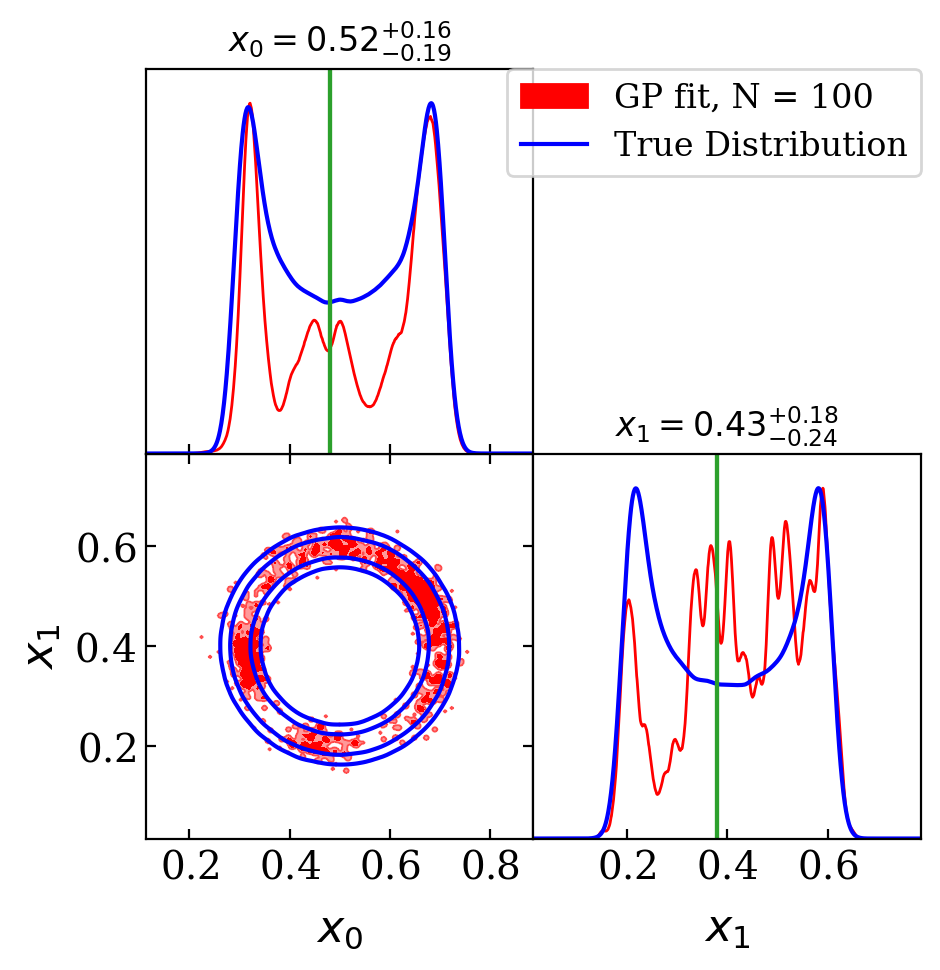

In [ ]:
size = int(5e5)
rs = np.random.normal(loc=mean_r,scale=scale,size=size)
thetas = 2*np.pi*np.random.rand(size)
xs = abs(rs)*np.cos(thetas)+0.5
ys = abs(rs)*np.sin(thetas)+0.4
xys = np.array([xs,ys]).T

labels = [r"x_{0}".format(i) for i in range(ndim)]
names = [r"x_{0}".format(i) for i in range(ndim)]
ranges =  np.array(ndim*[[0,1]])
true_samples = MCSamples(samples=xys,names=names[:2], labels = labels[:2],ranges=ranges[:2]) # a comparison run
gp_samples = MCSamples(samples=samples,names=names, labels = labels,ranges=ranges)
g = plots.get_subplot_plotter(subplot_size=2.5,subplot_size_ratio=1)
# g.settings.num_plot_contours = 2
g.settings.axes_labelsize = 18
g.settings.axes_fontsize = 16
g.settings.legend_fontsize = 14
g.settings.title_limit_fontsize = 14
g.triangle_plot([gp_samples,true_samples], names[:2],filled=[True,False],contour_colors=['red','blue'],
                                legend_labels=[f'GP fit, N = {gp.train_y.shape[0]}','True Distribution'],
                                contour_lws=[1,1.5],title_limit=1,)
                                # markers = dict(zip(names[:2],[0.])),
                                # marker_args={'lw': 1.25, 'ls': '-', 'color': 'C2'}) # type: ignore

locs = np.array([0.5,0.4])
for i in range(2):
    ax = g.subplots[i,i]
    ax.axvline(locs[i]-scale, color='C2', ls='-')
    ax.axvline(locs[i]-scale, color='C2', ls='-')


